# House Price Prediction in Canada


In [3]:

# ## Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Load Dataset

In [4]:

data = pd.read_csv("/Users/manish/Documents/Adobe/ca_real_state.csv")


## Explore Dataset

In [7]:

print(data.head())
print(data.info())
print(data.describe())

# Check for missing values
print(data.isnull().sum())


    Price  Bedrooms  Bathrooms  SqFt       City Province  Year_Built  \
0  873630         5          2  1010   Montreal       BC        1960   
1  377869         2          2  3591    Toronto       ON        1958   
2  128030         4          1  3823   Montreal       ON        2002   
3  117730         3          2  2848   Montreal       QC        1975   
4  292476         4          1  3659  Vancouver       QC        2018   

        Type  Garage  Lot_Area  
0      Condo       1      7919  
1      House       1      7304  
2      House       0      4548  
3  Apartment       1      3374  
4      Condo       1      1281  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Price       5000 non-null   int64 
 1   Bedrooms    5000 non-null   int64 
 2   Bathrooms   5000 non-null   int64 
 3   SqFt        5000 non-null   int64 
 4   City        5000 

 ## Data Preprocessing

Check skewness

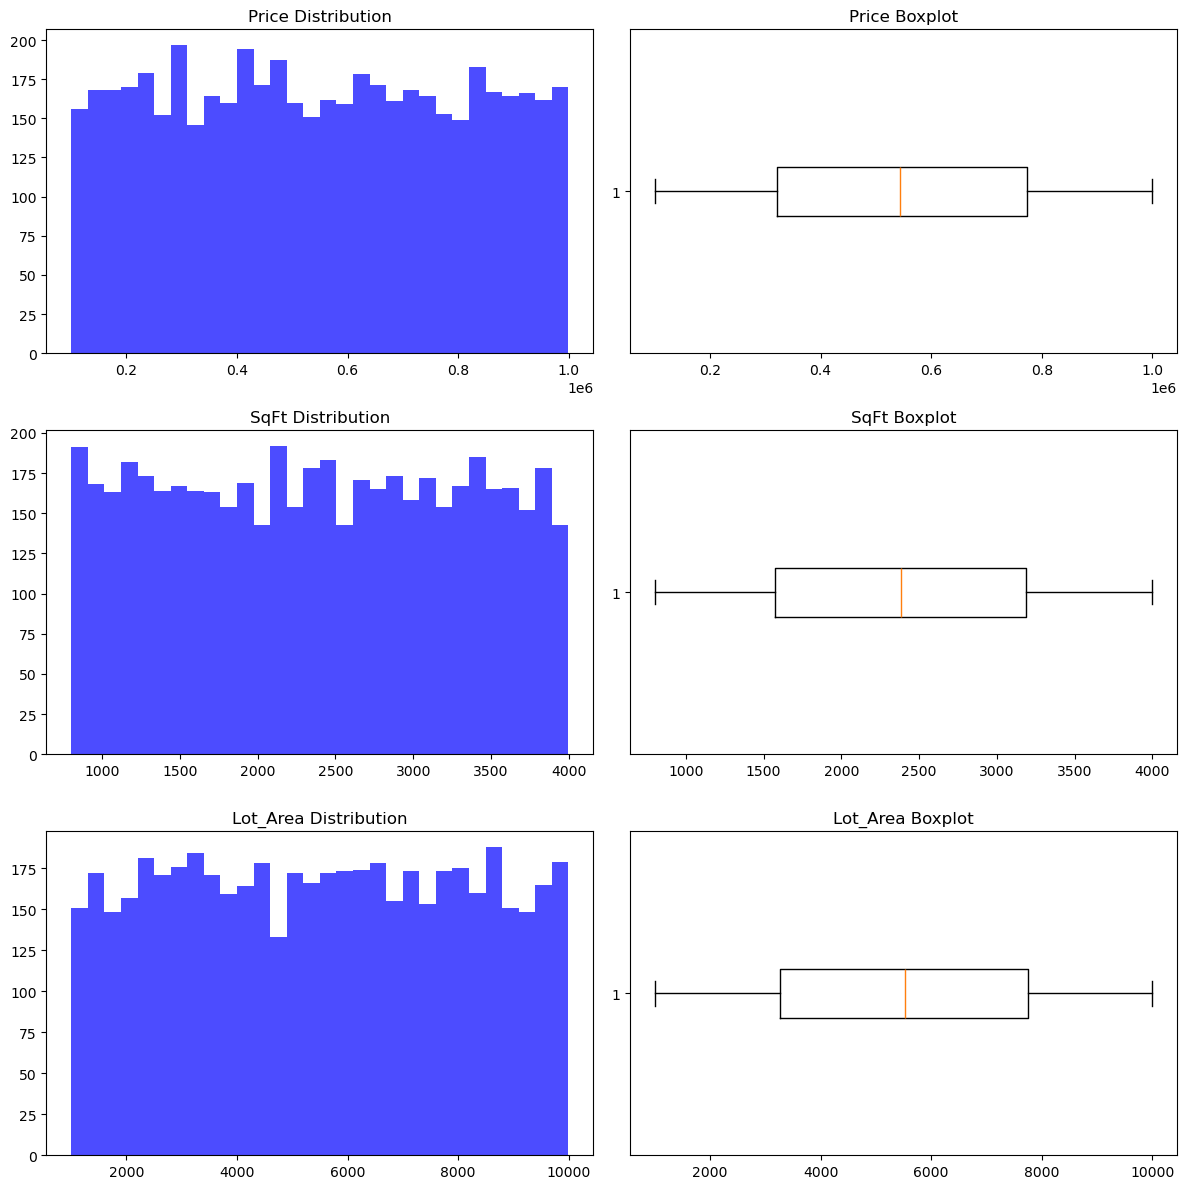

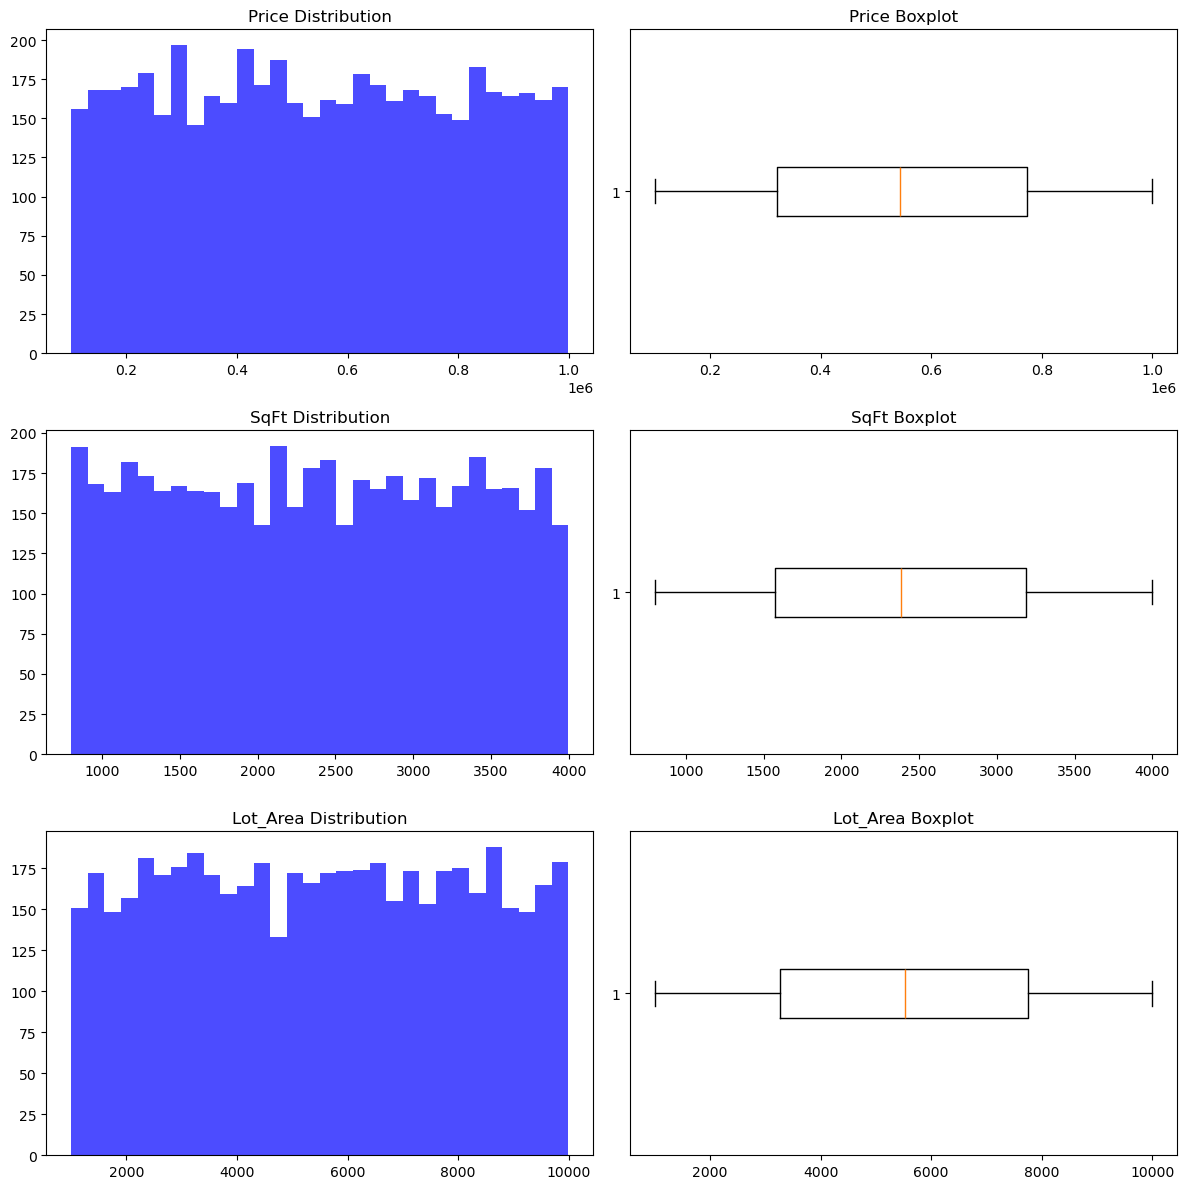

Price       0.021263
SqFt        0.002840
Lot_Area    0.003512
dtype: float64

In [9]:
# Check for outliers and distribution in numerical features
numerical_features = ["Price", "SqFt", "Lot_Area"]

# Plot histograms and boxplots to visualize distributions and outliers
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 12))

for i, feature in enumerate(numerical_features):
    # Histogram
    axes[i, 0].hist(data[feature], bins=30, color='blue', alpha=0.7)
    axes[i, 0].set_title(f"{feature} Distribution")
    # Boxplot
    axes[i, 1].boxplot(data[feature], vert=False)
    axes[i, 1].set_title(f"{feature} Boxplot")

plt.tight_layout()
plt.show()

# Check skewness of numerical features
skewness = data[numerical_features].skew()

skewness# Check for outliers and distribution in numerical features
numerical_features = ["Price", "SqFt", "Lot_Area"]

# Plot histograms and boxplots to visualize distributions and outliers
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 12))

for i, feature in enumerate(numerical_features):
    # Histogram
    axes[i, 0].hist(data[feature], bins=30, color='blue', alpha=0.7)
    axes[i, 0].set_title(f"{feature} Distribution")
    # Boxplot
    axes[i, 1].boxplot(data[feature], vert=False)
    axes[i, 1].set_title(f"{feature} Boxplot")

plt.tight_layout()
plt.show()

# Check skewness of numerical features
skewness = data[numerical_features].skew()

skewness

Outlier detection

In [13]:
# Detect and handle outliers using the IQR method

def detect_outliers_iqr(data, column):
    """Detect outliers based on the IQR method."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detect outliers in numerical features
outliers = {}
for col in ["Price", "SqFt", "Lot_Area"]:
    outliers[col] = detect_outliers_iqr(data, col)

# Count of outliers
outlier_counts = {col: len(outliers[col]) for col in outliers}
outlier_counts

# Remove outliers from the dataset
for col in ["Price", "SqFt", "Lot_Area"]:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Check new dataset shape
data.shape


(5000, 10)

In [15]:
# Feature Engineering
data['Age'] = 2024 - data['Year_Built']  # Calculate age of the property
data['Bedrooms_Bathrooms'] = data['Bedrooms'] * data['Bathrooms']  # Interaction feature
data['Price_per_SqFt'] = data['Price'] / data['SqFt']  # Price per square foot

# Verify new features
engineered_features = ['Age', 'Bedrooms_Bathrooms', 'Price_per_SqFt']
data[engineered_features].describe()


,Age,Bedrooms_Bathrooms,Price_per_SqFt
count,5000.000000,5000.000000,5000.000000
mean,38.314800,6.082200,280.832068
std,20.954893,3.989615,206.321363
min,2.000000,1.000000,26.013959
25%,20.000000,3.000000,134.343953
50%,39.000000,5.000000,226.645100
75%,56.000000,9.000000,358.076224
max,74.000000,15.000000,1219.123321


In [17]:

# Fill missing values (if any) or drop rows/columns
data.fillna(method='ffill', inplace=True)

# Separate features and target
X = data.drop("Price", axis=1)
y = data["Price"]

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns


/var/folders/dy/ysjjzh0121qb38fzyck4zbdh0000gn/T/ipykernel_23003/4233479907.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [19]:

# ## Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Preprocessing Pipelines

In [22]:

# Pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)


## Modeling Pipeline

In [25]:

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


## Train the Model

In [28]:

model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Bedrooms', 'Bathrooms', 'SqFt', 'Year_Built', 'Garage', 'Lot_Area',
       'Age', 'Bedrooms_Bathrooms', 'Price_per_SqFt'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['City', 'Province', 'Type'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

## Evaluate the Model

In [30]:

# Predictions
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

# Metrics
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))


Train MAE: 2332.062495
Test MAE: 6330.623710000001
Train RMSE: 3361.809571432163
Test RMSE: 9200.65753703728


## Feature Importance (for RandomForest)

In [32]:

model = model_pipeline.named_steps['model']
if hasattr(model, 'feature_importances_'):
    feature_names = numerical_features.tolist() + list(
        model_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
    feature_importances = pd.DataFrame(
        {'Feature': feature_names, 'Importance': model.feature_importances_}
    ).sort_values(by='Importance', ascending=False)
    print(feature_importances)


               Feature  Importance
8       Price_per_SqFt    0.788505
2                 SqFt    0.209631
5             Lot_Area    0.000354
6                  Age    0.000221
3           Year_Built    0.000221
7   Bedrooms_Bathrooms    0.000196
0             Bedrooms    0.000127
1            Bathrooms    0.000089
4               Garage    0.000062
17         Province_QC    0.000056
15         Province_BC    0.000056
16         Province_ON    0.000055
19          Type_Condo    0.000054
20          Type_House    0.000054
18      Type_Apartment    0.000050
9         City_Calgary    0.000049
10       City_Montreal    0.000047
13      City_Vancouver    0.000045
11         City_Ottawa    0.000045
12        City_Toronto    0.000044
14         Province_AB    0.000039


## Save the Model

In [34]:
import joblib
joblib.dump(model_pipeline, 'house_price_model.pkl')


['house_price_model.pkl']

 ## Load and Use the Model

In [38]:
# Load the model
loaded_model = joblib.load('house_price_model.pkl')

# Adjust sample data to include all columns (including engineered features) expected by the model
sample_data = pd.DataFrame({
    'Province': ['Manitoba'],  
    'City': ['Winnipeg'],      
    'Type': ['Detached'],      
    'SqFt': [1500],
    'Bedrooms': [3],
    'Bathrooms': [2],
    'Garage': [1],            
    'Year_Built': [2005],     
    'Lot_Area': [5000],
    # New engineered features
    'Age': [2024 - 2005],
    'Bedrooms_Bathrooms': [3 * 2],
    'Price_per_SqFt': [0]  # Placeholder, since 'Price' is not known
})

# Note: Preprocessor will automatically calculate one-hot encodings and scale numerical features.

# Make a prediction
sample_prediction = loaded_model.predict(sample_data)
print("Sample Prediction:", sample_prediction)


Sample Prediction: [103695.27]
